## POOL BPT_WETH


Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [11]:
EXPERIMENT_ID = 82

X_NAME = 'BPT'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [12]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [13]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [14]:
def find_longest_blocked_sequence(s: pd.Series):
    cnt = 0
    max_cnt = 0
    
    for index, value in s.items():
        if value != 'SUCCESS':
            cnt += 1
        else:
            max_cnt = max(max_cnt, cnt)
            cnt = 0
    
    return max(max_cnt, cnt)

In [15]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [16]:
def find_longest_blocked_sequence(s: pd.Series):
    cnt = 0
    max_cnt = 0
    
    for index, value in s.items():
        if value != 'SUCCESS':
            cnt += 1
        else:
            max_cnt = max(max_cnt, cnt)
            cnt = 0
    
    return max(max_cnt, cnt)

In [17]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [18]:
swaps0_df.head()

id token_in token_out  token_in_amount  token_out_amount_min  \
0   1      BPT      WETH         0.028860                   0.0   
1   2     WETH       BPT         0.100000                   0.0   
2   3     WETH       BPT         0.050000                   0.0   
3   4     WETH       BPT         1.000000                   0.0   
4   7      BPT      WETH         0.010674                   0.0   

   token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0          5.882351    0.023529          MITIGATOR_OFF                NaN   
1          0.001154    0.000400          MITIGATOR_OFF                NaN   
2          0.000557    0.000200          MITIGATOR_OFF                NaN   
3          0.008919    0.004000          MITIGATOR_OFF                NaN   
4          0.212282    0.000849          MITIGATOR_OFF                NaN   

   out_amount_diff  slice_factor  slice_factor_curve   status  block_number  \
0              NaN           NaN                 NaN  SUCCESS          70.0   
1              NaN           NaN                 NaN  SUCCESS         107.0   
2              NaN           NaN                 NaN  SUCCESS         121.0   
3              NaN           NaN                 NaN  SUCCESS         223.0   
4              NaN           NaN                 NaN  SUCCESS       31426.0   

      block_timestamp transaction_timestamp  \
0 2020-05-31 20:25:38   2020-05-31 20:25:35   
1 2020-05-31 20:34:53   2020-05-31 20:34:44   
2 2020-05-31 20:38:23   2020-05-31 20:38:21   
3 2020-05-31 21:03:53   2020-05-31 21:03:51   
4 2020-06-06 07:04:38   2020-06-06 07:04:33   

                                                 txd  \
0  0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...   
1  0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...   
2  0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...   
3  0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...   
4  0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...   

                                       sender  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
1  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
2  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
3  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e   

                                           to  transaction_id  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a               1   
1  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               2   
2  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               3   
3  0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6               4   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e               7   

   reserve_X_before  reserve_Y_before  k_before  price_X_cumulative_before  \
0          0.020000          10.00000  0.200000                          0   
1          0.048860           4.09412  0.200039                          0   
2          0.047706           4.19372  0.200067                      46505   
3          0.047150           4.24352  0.200081                      64965   
4          0.001878           0.25000  0.000469                     202666   

   price_Y_cumulative_before  is_volatility_mitigator_on_before  reserve_X  \
0                          0                              False   0.048860   
1                          0                              False   0.047706   
2                          6                              False   0.047150   
3                          9                              False   0.038231   
4                         26                              False   0.012551   

   reserve_Y         k  price_X_cumulative  price_Y_cumulative  \
0   4.094120  0.200039                   0                   0   
1   4.193720  0.200067               46505                   6   
2   4.243520  0.200081               64965                   9   
3   5.239520  0.200311              202666                  26   
4   0.036869  0.000463            62524871                3541   

   is_volatility_miti

In [19]:
swaps0_df

id token_in token_out  token_in_amount  token_out_amount_min  \
0        1      BPT      WETH         0.028860                   0.0   
1        2     WETH       BPT         0.100000                   0.0   
2        3     WETH       BPT         0.050000                   0.0   
3        4     WETH       BPT         1.000000                   0.0   
4        7      BPT      WETH         0.010674                   0.0   
...    ...      ...       ...              ...                   ...   
3150  3185     WETH       BPT         0.003000                   0.0   
3151  3186     WETH       BPT         0.004000                   0.0   
3152  3187     WETH       BPT         0.005000                   0.0   
3153  3188      BPT      WETH    308326.263648                   0.0   
3154  3189     WETH       BPT         0.002000                   0.0   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0             5.882351    0.023529          MITIGATOR_OFF                NaN   
1             0.001154    0.000400          MITIGATOR_OFF                NaN   
2             0.000557    0.000200          MITIGATOR_OFF                NaN   
3             0.008919    0.004000          MITIGATOR_OFF                NaN   
4             0.212282    0.000849          MITIGATOR_OFF                NaN   
...                ...         ...                    ...                ...   
3150      64785.696636    0.000012          MITIGATOR_OFF                NaN   
3151      64341.448375    0.000016          MITIGATOR_OFF                NaN   
3152      58116.134881    0.000020          MITIGATOR_OFF                NaN   
3153          0.015737    0.000063          MITIGATOR_OFF                NaN   
3154      67556.963219    0.000008          MITIGATOR_OFF                NaN   

      out_amount_diff  slice_factor  slice_factor_curve   status  \
0                 NaN           NaN                 NaN  SUCCESS   
1                 NaN           NaN                 NaN  SUCCESS   
2                 NaN           NaN                 NaN  SUCCESS   
3                 NaN           NaN                 NaN  SUCCESS   
4                 NaN           NaN                 NaN  SUCCESS   
...               ...           ...                 ...      ...   
3150              NaN           NaN                 NaN  SUCCESS   
3151              NaN           NaN                 NaN  SUCCESS   
3152              NaN           NaN                 NaN  SUCCESS   
3153              NaN           NaN                 NaN  SUCCESS   
3154              NaN           NaN                 NaN  SUCCESS   

      block_number     block_timestamp transaction_timestamp  \
0             70.0 2020-05-31 20:25:38   2020-05-31 20:25:35   
1            107.0 2020-05-31 20:34:53   2020-05-31 20:34:44   
2            121.0 2020-05-31 20:38:23   2020-05-31 20:38:21   
3            223.0 2020-05-31 21:03:53   2020-05-31 21:03:51   
4          31426.0 2020-06-06 07:04:38   2020-06-06 07:04:33   
...            ...                 ...                   ...   
3150     2587373.0 2021-08-24 00:51:23   2021-08-24 00:51:09   
3151     2587406.0 2021-08-24 00:59:38   2021-08-24 00:59:34   
3152     2587517.0 2021-08-24 01:27:23   2021-08-24 01:27:16   
3153     2589754.0 2021-08-24 10:46:38   2021-08-24 10:46:30   
3154     2747481.0 2021-09-20 19:58:23   2021-09-20 19:58:11   

                                                    txd  \
0     0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...   
1     0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...   
2     0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...   
3     0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...   
4     0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...   
...                                                 ...   
3150  0x957b4936e85036ee20263b4e92fb47a5d92ce636e665...   
3151  0x434eae879295625399358b088daffab5e28fe426ce3b...   
3152  0x6810a641f416cb9ad102ac82a73ad3c375e02f75e137...   
3153  

In [20]:
swaps0_df.status.value_counts()

SUCCESS    3155
Name: status, dtype: int64

In [21]:
swaps1_df.status.value_counts()

SUCCESS                             2690
BLOCKED_BY_VOLATILITY_MITIGATION     402
NOT_ENOUGH_RESERVES                   63
Name: status, dtype: int64

In [22]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.12741679873217115


In [23]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                3065
NOT_REACHED              63
CANT_CONSULT_ORACLE      27
Name: mitigator_check_status, dtype: int64

In [24]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.00855784469096672


In [25]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    5
CLIPPED    1
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    5
CLIPPED    1
Name: status, dtype: int64


**564 out of 3155** have been **blocked by the volatility mitigation mechanism**. Only in about **0.008%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

In [18]:
swaps1_df[swaps1_df.status != 'SUCCESS'].sender.value_counts()

0x7a250d5630b4cf539739df2c5dacb4c659f2488d    176
0x693c188e40f760ecf00d2946ef45260b84fbc43e    107
0xf1ad4bfdf8829d55ec0ce7900ef9d122b2610673     69
0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66     21
0x8a3960472b3d63894b68df3f10f58f11828d6fd9     18
0x40a7cb7052c274cc2e568c324b4c5d94383bec4f     16
0x9021c84f3900b610ab8625d26d739e3b7bff86ab     12
0xe33c8e3a0d14a81f0dd7e174830089e82f65fc85     10
0x762ed657b76372f8c08c6f7e0aa4170658c4ca35      5
0x0000000000007f150bd6f54c40a34d7c3d5e9f56      4
0x728bbe9bbee3af78ad611315076621865950b344      4
0xeca2e07abc83c78a7178c46b84962af86de342ff      4
0x480ea104ff7063ed0af41c98d8ef2457afe2a41c      4
0x000000000025d4386f7fb58984cbe110aee3a4c4      1
0xe929bcd423ccdce094ed5a4f2ab092070655f0e2      1
0xbfd5362a12bae3dd1d7b7d03f14dbff7c851dd6f      1
0xb0ac3a4b6762ee388e65f5b005ccdd36867d20c6      1
0xff26d7d5710b916b62c8317c9228c06a38446203      1
0x000000000a2daefe11b26dcdaecde7d33ad03e9d      1
0x175789024955c56b06a618806fc13df71d08a377      1


In [2]:
#swaps1_df[swaps1_df.to == '0x7a250d5630b4cf539739df2c5dacb4c659f2488d']

In [1]:
#swaps1_df[swaps1_df.to == '0x7a250d5630b4cf539739df2c5dacb4c659f2488d']

### Table of transactions blocked by Volatility Mitigation Mechanism

In [21]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']]

token_in token_out  token_in_amount  token_out_amount  slice_factor  \
3        WETH       BPT         1.000000          0.008919          24.0   
10       WETH       BPT         0.455837          0.061999          30.0   
11       WETH       BPT         0.457138          0.062136          30.0   
14        BPT      WETH         0.065503          0.413138          30.0   
33       WETH       BPT         1.091553          0.130359          78.0   
36        BPT      WETH         0.097473          0.258415          28.0   
38       WETH       BPT         0.457573          0.115039          43.0   
39        BPT      WETH         0.108756          0.233063          28.0   
66       WETH       BPT         0.622761          0.116408          51.0   
67        BPT      WETH         0.080566          0.227550          24.0   
71       WETH       BPT         0.277405          0.054354          21.0   
73        BPT      WETH         0.082613          0.325235          29.0   
74       WETH       BPT         0.737465          0.095332          50.0   
75        BPT      WETH         0.070027          0.285334          25.0   
77        BPT      WETH         0.120123          0.581702          28.0   
78       WETH       BPT         0.465051          0.062759          18.0   
80        BPT      WETH         0.163336          0.998387          20.0   
82        BPT      WETH         0.102957          0.768293          14.0   
84        BPT      WETH         0.108163          0.854295          15.0   
90        BPT      WETH         0.087454          0.927198          14.0   
91       WETH       BPT         0.708539          0.053057           9.0   
92        BPT      WETH         0.147798          1.449180          23.0   
93       WETH       BPT         0.191436          0.015245           3.0   
95       WETH       BPT         0.414733          0.036691           6.0   
1732      BPT      WETH       494.784081        157.587805         100.0   
1735      BPT      WETH        30.867565         92.042703         100.0   
1739      BPT      WETH        15.656916         64.457687          56.0   
1743      BPT      WETH        26.152808         88.721941          95.0   
1746      BPT      WETH        14.735481         64.503806          54.0   
1747      BPT      WETH        16.235134         68.627377          60.0   
1750      BPT      WETH        24.636451         89.907117          92.0   
1754      BPT      WETH         8.841230         35.000707          28.0   
1758      BPT      WETH        23.434218         73.897974          79.0   
1760      BPT      WETH        30.216991         87.467750         100.0   
1761      BPT      WETH         9.755480         43.000284          34.0   
1766      BPT      WETH         7.968059         37.444473          28.0   
1778      BPT      WETH         6.110583         14.619676          15.0   
1791      BPT      WETH         2.185561          4.248091           5.0   
1793      BPT      WETH         2.204469          4.330799           5.0   
1795      BPT      WETH         1.683966          3.347436           4.0   
1798      BPT      WETH         3.225321          6.248354           7.0   
1803      BPT      WETH         2.933225          5.845643           6.0   
1810      BPT      WETH         3.852959          7.031365           8.0   
1813      BPT      WETH         3.953829          7.463667           8.0   
1814      BPT      WETH         4.212541          7.914088           9.0   
1817      BPT      WETH         2.620759          5.234487           6.0   
1818      BPT      WETH         4.451101          8.586963          10.0   
1823      BPT      WETH         2.540264          4.749506           5.0   
1826      BPT      WETH         4.160535          7.825433           9.0   
1829      BPT      WETH        12.029495         20.526977          25.0   
1831      BPT      WETH         1.673797          3.160809           4.0   
1836      BPT      WETH         5.544222          9.9

Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

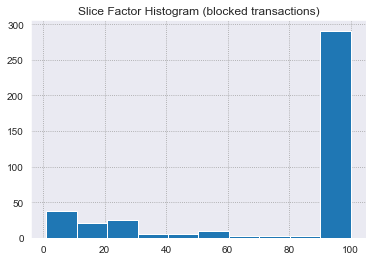

In [22]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

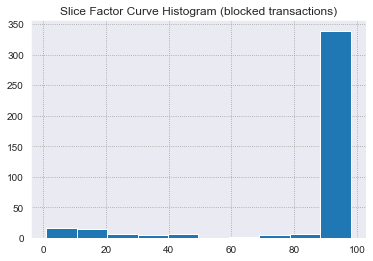

In [23]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

In [24]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)').update_xaxes(categoryorder='total descending')
fig.show()

Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which weren't checked therefore by volatility mitigation mechanism

**It can be seen that almost all of the transactions with a slice factor greater than 20 are blocked. The majority of the swaps have a slice factor, eithe near 0, or near 100. Below, it will be examined the cause of so many blocked transactions with a small slice factor**

In [25]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor > 1], x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram').update_xaxes(categoryorder='total descending')
fig.show()

**Most blocked transactions have an out_amount_diff greater than 25. There is a very big concentraion of blocked swaps with extremely large amount difference**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

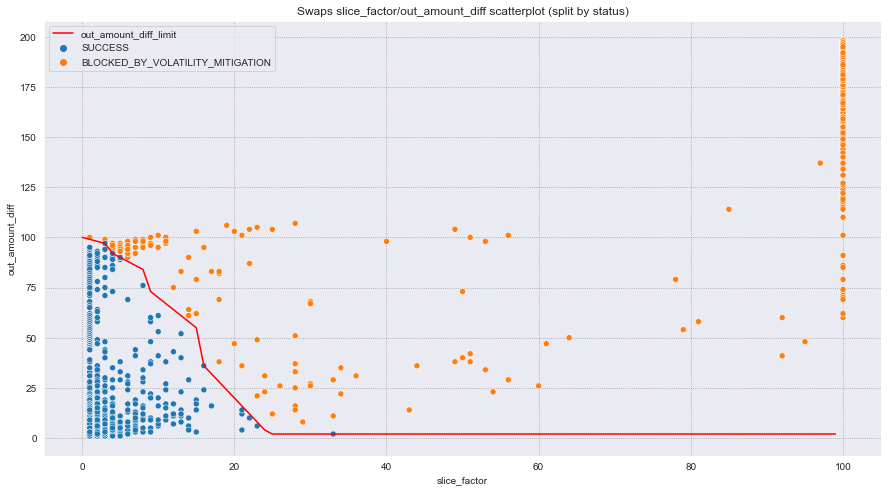

In [26]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**The successful and blocked transactions are not clustered**

Text(0, 0.5, 'Count')

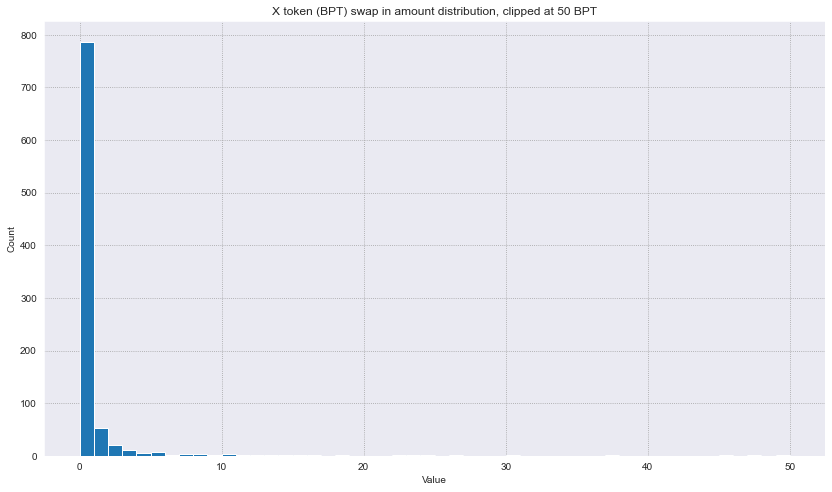

In [27]:
UPPER_LIMIT = 50


fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
#amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

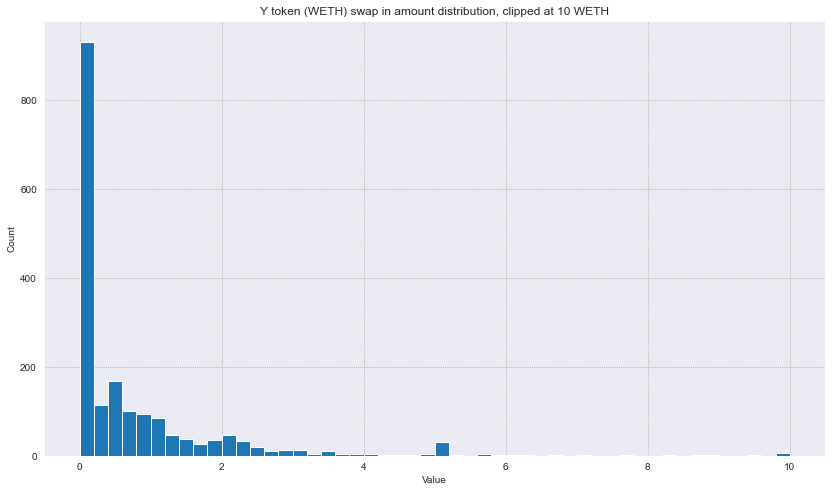

In [28]:
UPPER_LIMIT = 10

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

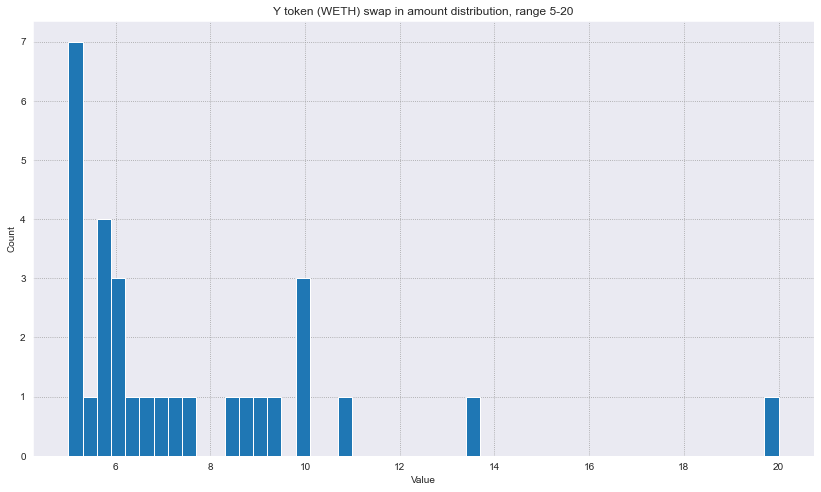

In [29]:
LOWER_LIMIT = 5
UPPER_LIMIT = 20
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

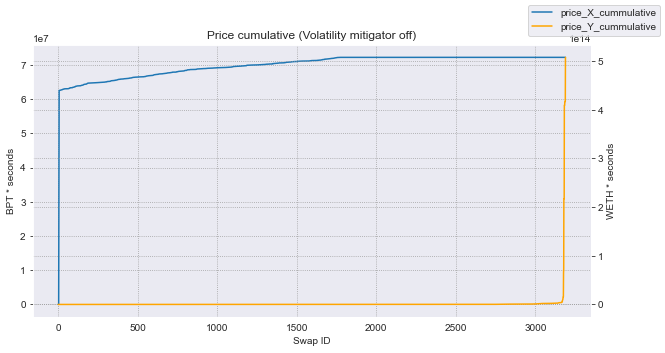

In [30]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

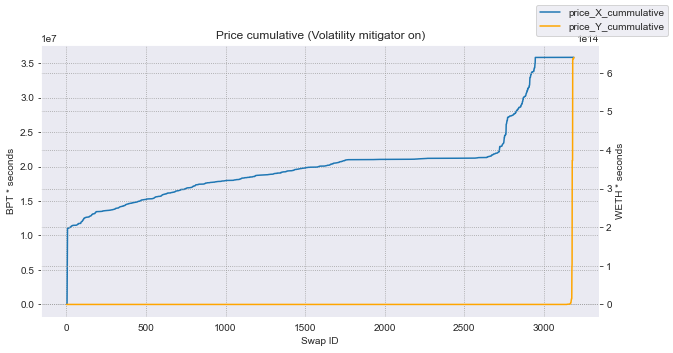

In [31]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

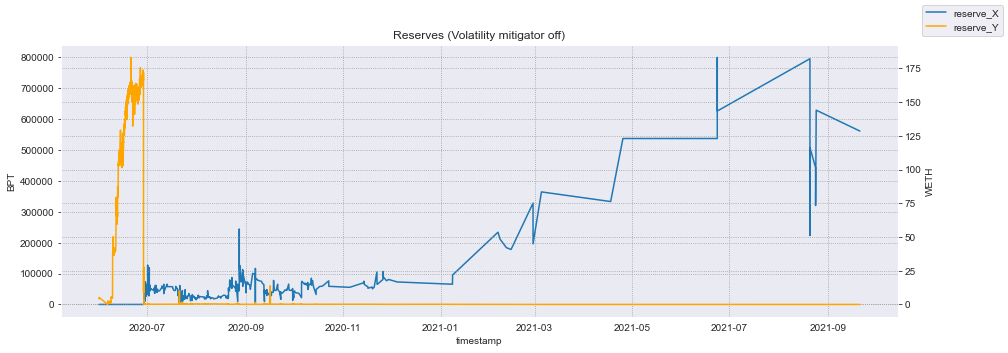

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

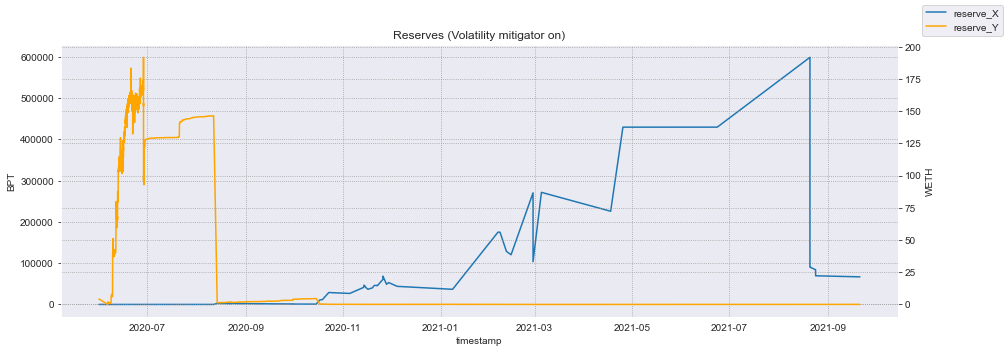

In [33]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

(18414.042372685184, 18475.042372685184)

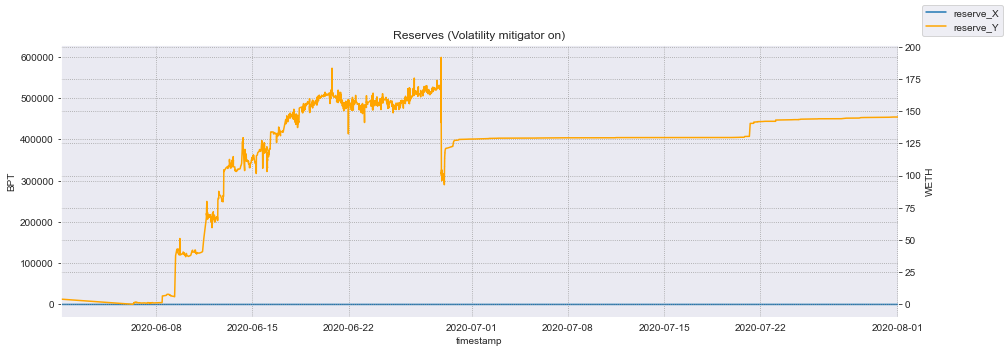

In [66]:
import datetime
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 1, 1,1,1), datetime.datetime(2020, 8, 1, 1, 1, 1))
# ax2.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, , 1, 1, 1))

In [19]:
#swaps1_df.iloc[1767:2700]

In [20]:
#swaps1_df.iloc[1767:2700][swaps1_df.iloc[1767:2700].status =='SUCCESS']

In [34]:
swaps1_df.txd.value_counts()

0x841df76f0745ae7244da1815add2d774eebab12aa43998774b004a61df1e46ee    1
0x350b66363e948ae19482004bdca6d39a03250de136ef759508439f5421a5248c    1
0xb4866eb618b96f3125776160bd489a03671b576d34078e3450b988e0cd42b44d    1
0xafa4ba6a01f7f8f938d8b12cf0e490f327ef9f2fab8e83fad17caca09673045c    1
0xf53c8e740492280c877148f9ed3ef224ad6982f8512bee31f54ca84c909b74bd    1
                                                                     ..
0x16215eefbdbb46129a66624cda2d8abd8b5995ea20661d014c5c1fdc0cdb817c    1
0x831ebb1d36b12dfa5f74b20d5f3e3e25eced0e684914ab98b7deb33b79f58eeb    1
0x2e632fb45d5740017b018a433b871599c678fd7a26db9e5f06342fe07658bacd    1
0xbff1e5bafc5b18e741022a119544b6483d37e15561b435ce3cf6681d294d2aed    1
0xcac4538f7ab42436a99f227bbae50505360e508aaa18637aa3651746f5e20051    1
Name: txd, Length: 3155, dtype: int64

In [35]:
swaps_df = pd.read_pickle('bpt_weth_swaps.pkl')

In [36]:
swaps1_df.head()

id token_in token_out  token_in_amount  token_out_amount_min  \
0   1      BPT      WETH         0.028860                   0.0   
1   2     WETH       BPT         0.100000                   0.0   
2   3     WETH       BPT         0.050000                   0.0   
3   4     WETH       BPT         1.000000                   0.0   
4   7      BPT      WETH         0.010674                   0.0   

   token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0          5.882351    0.023529    CANT_CONSULT_ORACLE                NaN   
1          0.001154    0.000400                CHECKED           0.001193   
2          0.000557    0.000200                CHECKED           0.000589   
3          0.008919         NaN                CHECKED           0.011334   
4          0.123655    0.000495    CANT_CONSULT_ORACLE                NaN   

   out_amount_diff  slice_factor  slice_factor_curve  \
0              NaN           NaN                 NaN   
1              3.0           3.0                 3.0   
2              5.0           2.0                 2.0   
3             23.0          24.0                96.0   
4              NaN           NaN                 NaN   

                             status  block_number     block_timestamp  \
0                           SUCCESS          70.0 2020-05-31 20:25:38   
1                           SUCCESS         107.0 2020-05-31 20:34:53   
2                           SUCCESS         121.0 2020-05-31 20:38:23   
3  BLOCKED_BY_VOLATILITY_MITIGATION         223.0 2020-05-31 21:03:53   
4                           SUCCESS       31426.0 2020-06-06 07:04:38   

  transaction_timestamp                                                txd  \
0   2020-05-31 20:25:35  0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...   
1   2020-05-31 20:34:44  0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...   
2   2020-05-31 20:38:21  0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...   
3   2020-05-31 21:03:51  0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...   
4   2020-06-06 07:04:33  0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...   

                                       sender  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
1  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
2  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
3  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e   

                                           to  transaction_id  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a               1   
1  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               2   
2  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               3   
3  0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6               4   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e               7   

   reserve_X_before  reserve_Y_before  k_before  price_X_cumulative_before  \
0          0.020000          10.00000  0.200000                          0   
1          0.048860           4.09412  0.200039                          0   
2          0.047706           4.19372  0.200067                      46505   
3          0.047150           4.24352  0.200081                      64965   
4          0.010797           0.25000  0.002699                     202666   

   price_Y_cumulative_before  is_volatility_mitigator_on_before  reserve_X  \
0                          0                               True   0.048860   
1                          0                               True   0.047706   
2                          6                               True   0.047150   
3                          9                               True   0.047150   
4                         26                               True   0.021470   

   reserve_Y         k  price_X_cumulative  price_Y_cumulative  \
0    4.09412  0.200039                   0                   0   
1    4.19372  0.200067               46505                   6   
2    4.24352  0.200081               64965                   9   
3   

In [37]:
swaps = swaps1_df.merge(swaps_df, left_on='txd', right_on='txd')

In [38]:
swaps['out_ratio'] = swaps['amount_out'] / swaps['token_out_amount']

In [39]:
swaps

id token_in_x token_out_x  token_in_amount  token_out_amount_min  \
0        1        BPT        WETH         0.028860                   0.0   
1        2       WETH         BPT         0.100000                   0.0   
2        3       WETH         BPT         0.050000                   0.0   
3        4       WETH         BPT         1.000000                   0.0   
4        7        BPT        WETH         0.010674                   0.0   
...    ...        ...         ...              ...                   ...   
3150  3185       WETH         BPT         0.003000                   0.0   
3151  3186       WETH         BPT         0.004000                   0.0   
3152  3187       WETH         BPT         0.005000                   0.0   
3153  3188        BPT        WETH    308326.263648                   0.0   
3154  3189       WETH         BPT         0.002000                   0.0   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0             5.882351    0.023529    CANT_CONSULT_ORACLE                NaN   
1             0.001154    0.000400                CHECKED           0.001193   
2             0.000557    0.000200                CHECKED           0.000589   
3             0.008919         NaN                CHECKED           0.011334   
4             0.123655    0.000495    CANT_CONSULT_ORACLE                NaN   
...                ...         ...                    ...                ...   
3150       6381.594301    0.000012    CANT_CONSULT_ORACLE                NaN   
3151       7226.699128    0.000016                CHECKED        7985.481389   
3152       7453.584092    0.000020                CHECKED        8713.688992   
3153          0.041639         NaN                CHECKED           0.223906   
3154       2590.612848    0.000008    CANT_CONSULT_ORACLE                NaN   

      out_amount_diff  slice_factor  slice_factor_curve  \
0                 NaN           NaN                 NaN   
1                 3.0           3.0                 3.0   
2                 5.0           2.0                 2.0   
3                23.0          24.0                96.0   
4                 NaN           NaN                 NaN   
...               ...           ...                 ...   
3150              NaN           NaN                 NaN   
3151              9.0          10.0                30.0   
3152             15.0          11.0                33.0   
3153            137.0         100.0                98.0   
3154              NaN           NaN                 NaN   

                                status  block_number     block_timestamp  \
0                              SUCCESS          70.0 2020-05-31 20:25:38   
1                              SUCCESS         107.0 2020-05-31 20:34:53   
2                              SUCCESS         121.0 2020-05-31 20:38:23   
3     BLOCKED_BY_VOLATILITY_MITIGATION         223.0 2020-05-31 21:03:53   
4                              SUCCESS       31426.0 2020-06-06 07:04:38   
...                                ...           ...                 ...   
3150                           SUCCESS     2587373.0 2021-08-24 00:51:23   
3151                           SUCCESS     2587406.0 2021-08-24 00:59:38   
3152                           SUCCESS     2587517.0 2021-08-24 01:27:23   
3153  BLOCKED_BY_VOLATILITY_MITIGATION     2589754.0 2021-08-24 10:46:38   
3154                           SUCCESS     2747481.0 2021-09-20 19:58:23   

     transaction_timestamp                                                txd  \
0      2020-05-31 20:25:35  0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...   
1      2020-05-31 20:34:44  0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...   
2      2020-05-31 20:38:21  0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...   
3      2020-05-31 21:03:51  0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...   
4      2020-06-06 07:04:33  0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...   
...                    ...

In [40]:
swaps.out_ratio.max()

7340952.819895766

In [41]:
swaps.sort_values('out_ratio', ascending=False)

id token_in_x token_out_x  token_in_amount  token_out_amount_min  \
2641  2676       WETH         BPT         0.008284                   0.0   
2672  2707       WETH         BPT         0.025739                   0.0   
2642  2677       WETH         BPT         0.036845                   0.0   
2543  2578       WETH         BPT         0.007257                   0.0   
2548  2583       WETH         BPT         0.001382                   0.0   
...    ...        ...         ...              ...                   ...   
2517  2552        BPT        WETH      1000.000000                   0.0   
2734  2769        BPT        WETH      3577.470093                   0.0   
2718  2753        BPT        WETH      5000.000000                   0.0   
2725  2760        BPT        WETH      2269.328673                   0.0   
2715  2750        BPT        WETH      1175.404707                   0.0   

      token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
2641          0.002524    0.000033                CHECKED           0.002596   
2672          0.007788    0.000103                CHECKED           0.007898   
2642          0.011223    0.000147                CHECKED           0.011546   
2543          0.002247    0.000029                CHECKED           0.002672   
2548          0.000428    0.000006                CHECKED           0.000480   
...                ...         ...                    ...                ...   
2517        122.233517         NaN                CHECKED        2813.300067   
2734        128.091136         NaN                CHECKED       11824.033359   
2718        128.280167         NaN                CHECKED       16474.628360   
2725        127.230688         NaN                CHECKED        7481.612054   
2715        125.079123         NaN                CHECKED        3871.917795   

      out_amount_diff  slice_factor  slice_factor_curve  \
2641              2.0           1.0                 1.0   
2672              1.0           1.0                 1.0   
2642              2.0           1.0                 1.0   
2543             17.0           1.0                 1.0   
2548             11.0           1.0                 1.0   
...               ...           ...                 ...   
2517            183.0         100.0                98.0   
2734            195.0         100.0                98.0   
2718            196.0         100.0                98.0   
2725            193.0         100.0                98.0   
2715            187.0         100.0                98.0   

                                status  block_number     block_timestamp  \
2641                           SUCCESS      175797.0 2020-07-01 08:37:23   
2672                           SUCCESS      181694.0 2020-07-02 09:11:38   
2642                           SUCCESS      175819.0 2020-07-01 08:42:53   
2543                           SUCCESS      166854.0 2020-06-29 19:21:38   
2548                           SUCCESS      167279.0 2020-06-29 21:07:53   
...                                ...           ...                 ...   
2517  BLOCKED_BY_VOLATILITY_MITIGATION      166222.0 2020-06-29 16:43:38   
2734  BLOCKED_BY_VOLATILITY_MITIGATION      276795.0 2020-07-18 21:26:53   
2718  BLOCKED_BY_VOLATILITY_MITIGATION      227014.0 2020-07-10 06:01:38   
2725  BLOCKED_BY_VOLATILITY_MITIGATION      235954.0 2020-07-11 19:16:38   
2715  BLOCKED_BY_VOLATILITY_MITIGATION      218860.0 2020-07-08 20:03:08   

     transaction_timestamp                                                txd  \
2641   2020-07-01 08:37:17  0xdfd9e524c67869e8d8dabc77b356d04f68ce022a9d5d...   
2672   2020-07-02 09:11:33  0x159b84c940129dad4bd8342922e8aa0259e03082681c...   
2642   2020-07-01 08:42:42  0x8170355e974aaf4125365ba0587a20a821c65949ec3a...   
2543   2020-06-29 19:21:26  0xf5db46ebed59f5346311767c5a9999c595b842545be4...   
2548   2020-06-29 21:07:46  0x8d45f2f06aa5e8774ab97693a7eed29c80005cb31312...   
...                    ...

In [83]:
pd.set_option('max_rows', 1510)

(18433.042372685184, 18444.042372685184)

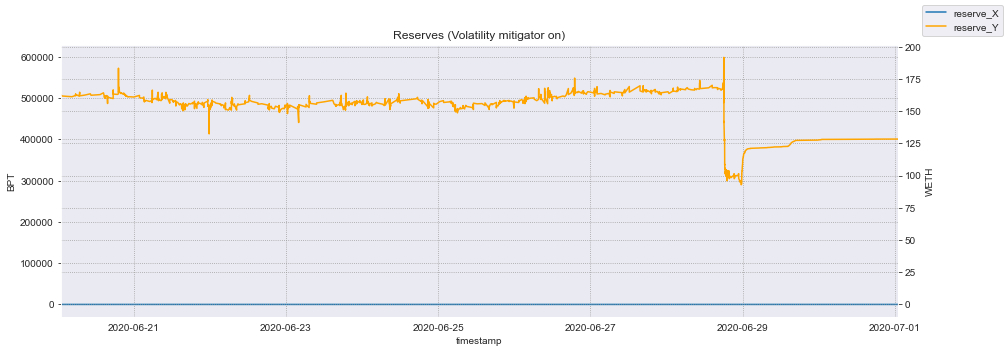

In [42]:
import datetime
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, 1, 1, 1, 1))
# ax2.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, , 1, 1, 1))

(18439.50070601852, 18473.042372685184)

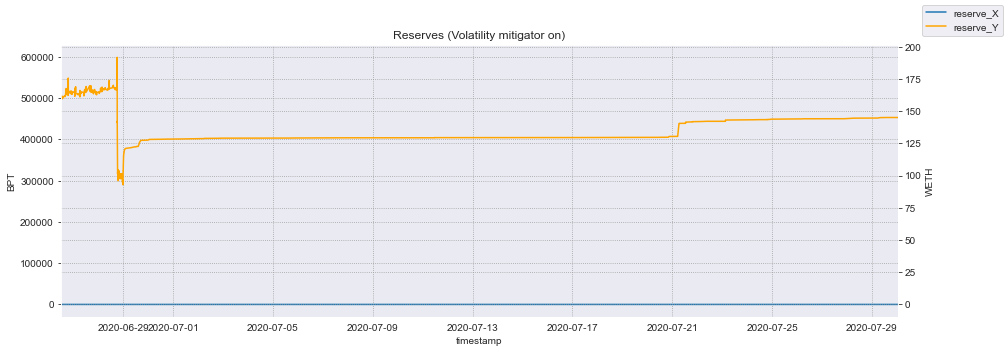

In [43]:
import datetime
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 26, 12,1,1), datetime.datetime(2020, 7, 30, 1, 1, 1))
# ax2.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, , 1, 1, 1))

In [3]:
#swaps1_df.iloc[2500:3000]

In [49]:
mints1_df['Date'] = pd.to_datetime(mints1_df.transaction_timestamp, unit='s')

In [53]:
burns1_df['Date'] = pd.to_datetime(burns1_df.transaction_timestamp, unit='s')

In [55]:
burns1_df

id  X_amount   Y_amount   timestamp   status  block_number  \
0    5  0.038184   4.243520  1590959175  CLIPPED           233   
1  347  0.417425   2.000000  1592042820  SUCCESS         72476   
2  362  0.119339   0.582595  1592067017  SUCCESS         74089   
3  391  3.280877  16.797741  1592129647  SUCCESS         78264   
4  453  2.659988  11.818349  1592202730  SUCCESS         83137   
5  479  2.575563  13.775960  1592243675  SUCCESS         85866   

   block_timestamp  transaction_timestamp  transaction_id  reserve_X_before  \
0       1590959183             1590959175               5          0.047150   
1       1592042828             1592042820             347         22.532278   
2       1592067023             1592067017             362         21.944273   
3       1592129648             1592129647             391         23.872558   
4       1592202743             1592202730             453         24.786211   
5       1592243678             1592243675             479         23.101950   

   reserve_Y_before     k_before  price_X_cumulative_before  \
0          4.243520     0.200081                     202666   
1        107.747317  2427.792503                   14191247   
2        106.736590  2342.256855                   14319330   
3        121.643682  2903.945889                   14579041   
4        109.754184  2720.390395                   14948432   
5        122.973247  2840.921801                   15161051   

   price_Y_cumulative_before  is_volatility_mitigator_on_before  reserve_X  \
0                         26                               True   0.008965   
1                     152284                               True  22.114853   
2                     157654                               True  21.824934   
3                     168789                               True  20.591682   
4                     185634                               True  22.126223   
5                     194357                               True  20.526386   

      reserve_Y             k  price_X_cumulative  price_Y_cumulative  \
0  1.000000e-12  8.965449e-15              202666                  26   
1  1.057473e+02  2.338586e+03            14191247              152284   
2  1.061540e+02  2.316804e+03            14319330              157654   
3  1.048459e+02  2.158954e+03            14579041              168789   
4  9.793583e+01  2.166950e+03            14948432              185634   
5  1.091973e+02  2.241426e+03            15161051              194357   

   is_volatility_mitigator_on                Date  
0                        True 2020-05-31 21:06:15  
1                        True 2020-06-13 10:07:00  
2                        True 2020-06-13 16:50:17  
3                        True 2020-06-14 10:14:07  
4                        True 2020-06-15 06:32:10  
5                        True 2020-06-15 17:54:35

In [60]:
#burns1_df.head()

(18439.50070601852, 18473.042372685184)

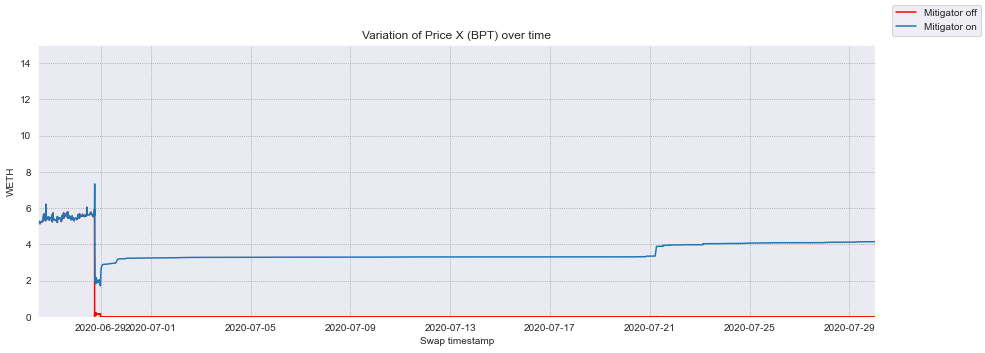

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 15)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 26, 12,1,1), datetime.datetime(2020, 7, 30, 1, 1, 1))


In [4]:
#mints1_df

In [5]:
#burns1_df

First spike , block one direction -> down block another -> ... _>mint (to 0)

(18441.50070601852, 18442.042372685184)

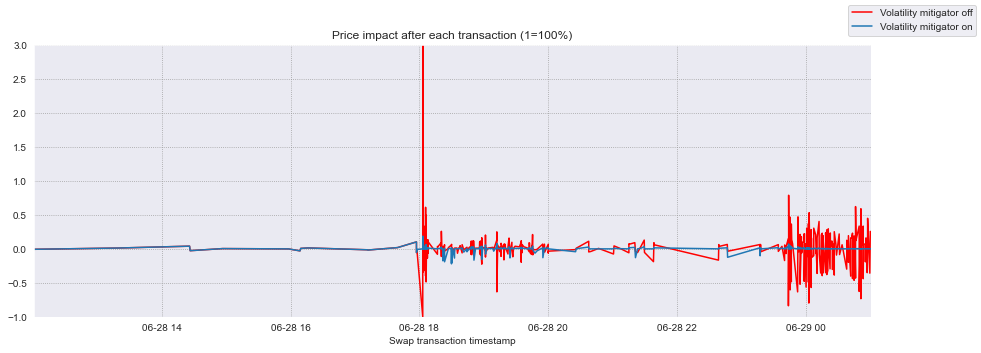

In [87]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 28, 12,1,1), datetime.datetime(2020, 6, 29, 1, 1, 1))


In [7]:
#swaps1_df.iloc[1760:2000]

In [6]:
#swaps1_df.iloc[2000:2500]

In [89]:
burns1_df['Date'] = pd.to_datetime(burns1_df['transaction_timestamp'], unit='s')

In [8]:
#burns1_df

In [9]:
#mints1_df

(18433.042372685184, 18444.042372685184)

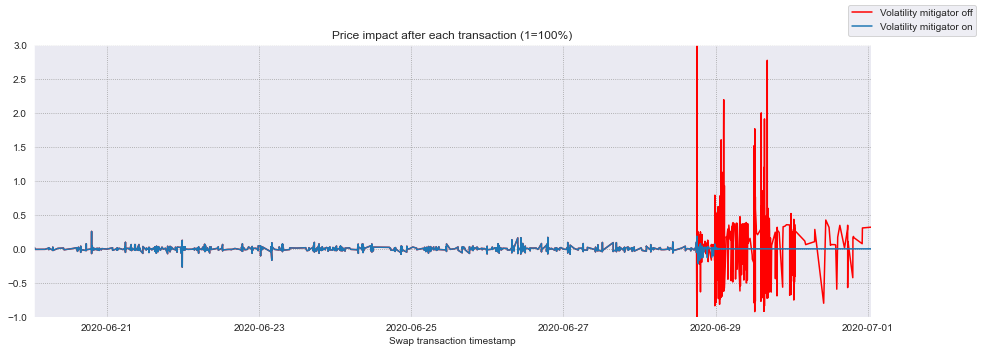

In [90]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()
ax.set_xlim(datetime.datetime(2020, 6, 20, 1,1,1), datetime.datetime(2020, 7, 1, 1, 1, 1))

In [10]:
#swaps.iloc[1500:3000]

In [11]:
#swaps_df

In [50]:
mints1_df.transaction_timestamp.head()

0    1590955688
1    1591427060
2    1591427757
3    1591610118
4    1591610762
Name: transaction_timestamp, dtype: int64

In [91]:
mints1_df['Date'] = pd.to_datetime(mints1_df['transaction_timestamp'], unit='s')

In [12]:
#mints1_df

In [13]:
#swaps.head(100)

In [92]:
swaps.head()[['amount_in', 'amount_out']]

amount_in  amount_out
0   0.028860    5.899406
1   0.100000    0.001160
2   0.050000    0.000559
3   1.000000    0.008956
4   0.010674    0.213296

In [93]:
swaps_df

token_in token_out      amount_in    amount_out  amount_usd  \
0         BPT      WETH       0.028860      5.899406  981.913051   
1        WETH       BPT       0.100000      0.001160   23.833425   
2        WETH       BPT       0.050000      0.000559   11.843336   
3        WETH       BPT       1.000000      0.008956  263.136013   
4         BPT      WETH       0.010674      0.213296   25.501870   
...       ...       ...            ...           ...         ...   
3151     WETH       BPT       0.004000  89828.981912    6.613954   
3152     WETH       BPT       0.005000  82946.747246    8.229742   
3153      BPT      WETH  308326.263648      0.013275   22.034868   
3154     WETH       BPT       0.002000  68782.696426    3.064949   
3155     WETH       BPT       0.000100   3128.234609    0.154912   

               timestamp                                      sender  \
0    2020-05-31 20:25:35  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
1    2020-05-31 20:34:44  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
2    2020-05-31 20:38:21  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
3    2020-05-31 21:03:51  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
4    2020-06-06 07:04:33  0x693c188e40f760ecf00d2946ef45260b84fbc43e   
...                  ...                                         ...   
3151 2021-08-24 00:59:34  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
3152 2021-08-24 01:27:16  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
3153 2021-08-24 10:46:30  0x0000000000007f150bd6f54c40a34d7c3d5e9f56   
3154 2021-09-20 19:58:11  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
3155 2021-09-23 16:27:37  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   

                                              to  \
0     0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
1     0x19bc2718782f2ae9d22c66d4d364394ecad1a771   
2     0x19bc2718782f2ae9d22c66d4d364394ecad1a771   
3     0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6   
4     0x693c188e40f760ecf00d2946ef45260b84fbc43e   
...                                          ...   
3151  0xce6e51ae6a876feb78df6bd7ce224935d249d61f   
3152  0xce6e51ae6a876feb78df6bd7ce224935d249d61f   
3153  0x0000000000007f150bd6f54c40a34d7c3d5e9f56   
3154  0x03711e1f9e1c1767690958a1fc6f4a88ec74253c   
3155  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   

                                                    txd  
0     0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...  
1     0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...  
2     0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...  
3     0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...  
4     0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...  
...                                                 ...  
3151  0x434eae879295625399358b088daffab5e28fe426ce3b...  
3152  0x6810a641f416cb9ad102ac82a73ad3c375e02f75e137...  
3153  0xfeb0ca3b8abb121c3abeecd2729b46a38ed4d972af87...  
3154  0x3228d95f8ced3dd842d050c83a44d980afb713a665c9...  
3155  0xa767b2d9d740db5adf2a15fcb593829f1065881b5be0...  

[3156 rows x 9 columns]

In [14]:
#swaps1_df.iloc[2000:2900]

In [37]:
find_longest_blocked_sequence(swaps1_df.status)

290

In [94]:
mints1_df['Date'] = pd.to_datetime(mints1_df.transaction_timestamp, unit='s')

In [15]:
#mints1_df

In [31]:
pd.set_option('max_rows', 3000)

In [64]:
swaps1_df.head()

id token_in token_out  token_in_amount  token_out_amount_min  \
0   1      BPT      WETH         0.028860                   0.0   
1   2     WETH       BPT         0.100000                   0.0   
2   3     WETH       BPT         0.050000                   0.0   
3   4     WETH       BPT         1.000000                   0.0   
4   7      BPT      WETH         0.010674                   0.0   

   token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0          5.882351    0.023529    CANT_CONSULT_ORACLE                NaN   
1          0.001154    0.000400                CHECKED           0.001193   
2          0.000557    0.000200                CHECKED           0.000589   
3          0.008919         NaN                CHECKED           0.011334   
4          0.123655    0.000495    CANT_CONSULT_ORACLE                NaN   

   out_amount_diff  slice_factor  slice_factor_curve  \
0              NaN           NaN                 NaN   
1              3.0           3.0                 3.0   
2              5.0           2.0                 2.0   
3             23.0          24.0                96.0   
4              NaN           NaN                 NaN   

                             status  block_number     block_timestamp  \
0                           SUCCESS          70.0 2020-05-31 20:25:38   
1                           SUCCESS         107.0 2020-05-31 20:34:53   
2                           SUCCESS         121.0 2020-05-31 20:38:23   
3  BLOCKED_BY_VOLATILITY_MITIGATION         223.0 2020-05-31 21:03:53   
4                           SUCCESS       31426.0 2020-06-06 07:04:38   

  transaction_timestamp                                                txd  \
0   2020-05-31 20:25:35  0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...   
1   2020-05-31 20:34:44  0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...   
2   2020-05-31 20:38:21  0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...   
3   2020-05-31 21:03:51  0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...   
4   2020-06-06 07:04:33  0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...   

                                       sender  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
1  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
2  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
3  0xf164fc0ec4e93095b804a4795bbe1e041497b92a   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e   

                                           to  transaction_id  \
0  0xf164fc0ec4e93095b804a4795bbe1e041497b92a               1   
1  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               2   
2  0x19bc2718782f2ae9d22c66d4d364394ecad1a771               3   
3  0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6               4   
4  0x693c188e40f760ecf00d2946ef45260b84fbc43e               7   

   reserve_X_before  reserve_Y_before  k_before  price_X_cumulative_before  \
0          0.020000          10.00000  0.200000                          0   
1          0.048860           4.09412  0.200039                          0   
2          0.047706           4.19372  0.200067                      46505   
3          0.047150           4.24352  0.200081                      64965   
4          0.010797           0.25000  0.002699                     202666   

   price_Y_cumulative_before  is_volatility_mitigator_on_before  reserve_X  \
0                          0                               True   0.048860   
1                          0                               True   0.047706   
2                          6                               True   0.047150   
3                          9                               True   0.047150   
4                         26                               True   0.021470   

   reserve_Y         k  price_X_cumulative  price_Y_cumulative  \
0    4.09412  0.200039                   0                   0   
1    4.19372  0.200067               46505                   6   
2    4.24352  0.200081               64965                   9   
3   

In [68]:
swaps1_df[swaps1_df.token_in == 'WETH'].head(100).iloc[0]['txd']

'0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b3795617001fc7cedf755f46'

In [16]:
#swaps1_df.iloc[2200:3015]

In [43]:
mints1_df['price'] = mints1_df['X_amount'] / mints1_df['Y_amount']

In [55]:
burns1_df['price'] = burns1_df['Y_amount'] / burns1_df['X_amount']
burns1_df['real_price_after'] = burns1_df['reserve_Y'] / burns1_df['reserve_X']
burns1_df['real_price_before'] = burns1_df['reserve_Y_before'] / burns1_df['reserve_X_before']

In [56]:
burns1_df['Date'] = pd.to_datetime(burns1_df.timestamp, unit='s')

In [17]:
#burns1_df

In [18]:
#mints1_df.iloc[30:]


**It can be seen that after a series of big transactions BPT_ETH that significantly decreased the price of BPT, all of the subsequent transaction (in both directions) become blocked for more than 6 hours. As a result, there is a chain of 290 consecutively blocked transactions happening in 6+ hours**

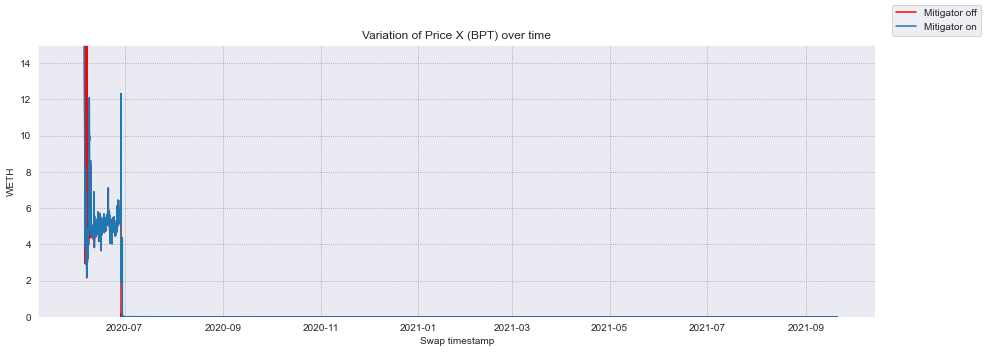

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 15)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

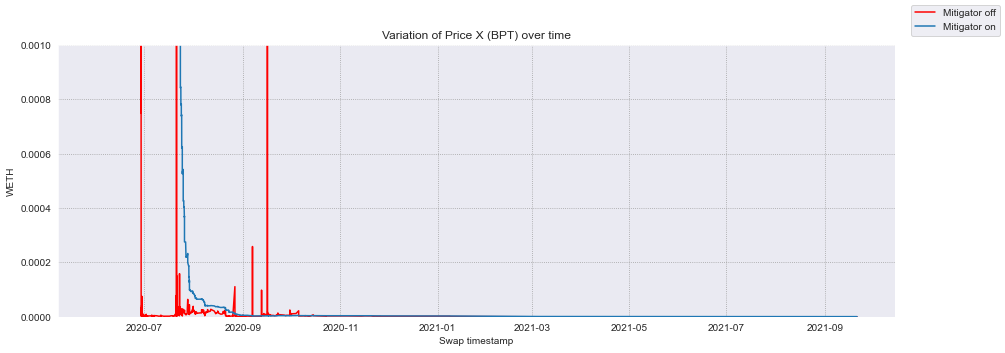

In [57]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.001)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

In [137]:
#swaps0_df.transaction_timestamp.min()

**It can be seen from the variation of price that the volatility mitigation mechanism slightly decreases the price variation in several cases, toward the end of the plot**

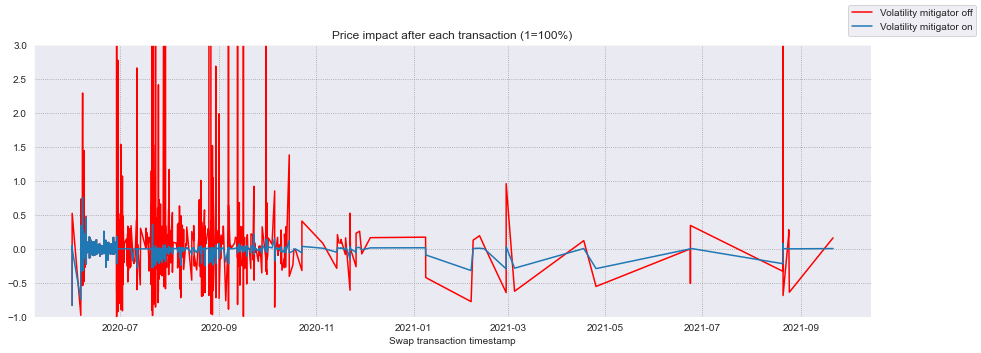

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

(18413.851099537038, 18890.832071759258)

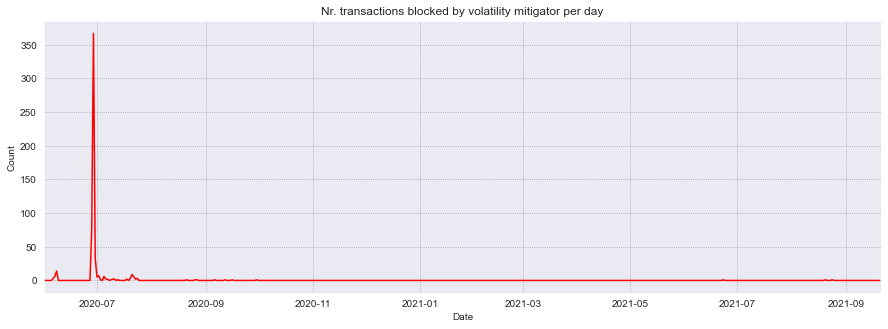

In [113]:
swaps1_indexed_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].copy()
swaps1_indexed_df.index = swaps1_indexed_df.transaction_timestamp
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.min()] = np.nan
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.max()] = np.nan
resampled24 = swaps1_indexed_df.resample('24h').size()
resampled24[0] -= 1
resampled24[-1] -= 1
resampled24.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled24.index, y=resampled24.values, linestyle='solid', color='red', marker=None,)

ax.set_title("Nr. transactions blocked by volatility mitigator per day")
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_xlim(swaps1_df.transaction_timestamp.min(), swaps1_df.transaction_timestamp.max())

**Most of the spikes (consecutive increases/decreases of price), are caused by MEV-bot sandwich attacks.**

In [114]:
swaps1_df[swaps1_df.price_diff > 0.4]

id token_in token_out  token_in_amount  token_out_amount_min  \
32    36     WETH       BPT         0.342230                   0.0   
122  133     WETH       BPT         8.701943                   0.0   

     token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
32           0.096318    0.001369                CHECKED           0.093709   
122          1.275335    0.034808                CHECKED           1.216827   

     out_amount_diff  slice_factor  slice_factor_curve   status  block_number  \
32               2.0          33.0                98.0  SUCCESS       37496.0   
122              4.0          21.0                84.0  SUCCESS       51086.0   

        block_timestamp transaction_timestamp  \
32  2020-06-07 08:22:08   2020-06-07 08:21:58   
122 2020-06-09 16:59:38   2020-06-09 16:59:27   

                                                   txd  \
32   0x323a2edacd4059df333220ad234e01043ddb401deb47...   
122  0xb4b178ac07862f7c1af81f717403dd8384410ebd35d0...   

                                         sender  \
32   0x40a7cb7052c274cc2e568c324b4c5d94383bec4f   
122  0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66   

                                             to  transaction_id  \
32   0x40a7cb7052c274cc2e568c324b4c5d94383bec4f              36   
122  0x860bd2dba9cd475a61e6d1b45e16c365f6d78f66             133   

     reserve_X_before  reserve_Y_before    k_before  \
32           0.394193           1.04781    0.413040   
122          7.364016          41.12922  302.876251   

     price_X_cumulative_before  price_Y_cumulative_before  \
32                    11395842                      44662   
122                   12651060                      86185   

     is_volatility_mitigator_on_before  reserve_X  reserve_Y           k  \
32                                True   0.297876   1.388671    0.413651   
122                               True   6.088682  49.796355  303.194151   

     price_X_cumulative  price_Y_cumulative  is_volatility_mitigator_on  \
32             11400587               45333                        True   
122            12651395               86196                        True   

      X_price  price_diff  
32   4.661917    0.753844  
122  8.178512    0.464329

Both 2 successful transactions with a price impact greater than 50% were not blocked as the TWAP coudn't be obtained from the oracle because of the missing observations

**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**